In [19]:
%matplotlib inline

In [1]:
import os
import sys
from pathlib import Path

# Set working directory to implementation folder
os.chdir('../implementation')
sys.path.insert(0, str(Path.cwd()))

print(f"Working directory: {Path.cwd()}")

Working directory: /home/zineddine/tests/MatchaTTS-Implementation-Analysis/implementation


In [2]:
import torch
import numpy as np
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
from pathlib import Path
import datetime as dt
import sys

sys.path.insert(0, str(Path.cwd()))

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Device: cuda


### load vocoder

In [3]:
from matcha.hifigan.models import Generator as HiFiGAN
from matcha.hifigan.config import v1
from matcha.hifigan.env import AttrDict
from matcha.hifigan.denoiser import Denoiser

def load_vocoder(path):
    h = AttrDict(v1)
    vocoder = HiFiGAN(h).to(DEVICE)
    vocoder.load_state_dict(torch.load(path, map_location=DEVICE)['generator'])
    vocoder.eval()
    vocoder.remove_weight_norm()
    return vocoder

VOCODER = load_vocoder(r"../vocoders/hifigan_T2_v1")
DENOISER = Denoiser(VOCODER, mode='zeros')

/home/zineddine/.local/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/tmp/ipykernel_17012/2509108235.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for 

Removing weight norm...


### Load original model

In [4]:
from matcha.models.matcha_tts import MatchaTTS as OriginalMatchaTTS

original_model = OriginalMatchaTTS.load_from_checkpoint(
    r"../original_model/matcha_ljspeech.ckpt", 
    map_location=DEVICE
)
original_model.eval()

/home/zineddine/.local/lib/python3.10/site-packages/lightning/fabric/utilities/cloud_io.py:73: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/zineddine/.local/lib/python3.10/site-packag

MatchaTTS(
  (encoder): TextEncoder(
    (emb): Embedding(178, 192)
    (prenet): ConvReluNorm(
      (conv_layers): ModuleList(
        (0-2): 3 x Conv1d(192, 192, kernel_size=(5,), stride=(1,), padding=(2,))
      )
      (norm_layers): ModuleList(
        (0-2): 3 x LayerNorm()
      )
      (relu_drop): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.5, inplace=False)
      )
      (proj): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
    )
    (encoder): Encoder(
      (drop): Dropout(p=0.1, inplace=False)
      (attn_layers): ModuleList(
        (0-5): 6 x MultiHeadAttention(
          (conv_q): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
          (conv_k): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
          (conv_v): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
          (query_rotary_pe): RotaryPositionalEmbeddings()
          (key_rotary_pe): RotaryPositionalEmbeddings()
          (conv_o): Conv1d(192, 192, kernel_size=(1,), stride=(1,))
          (dro

### load custom model

In [5]:
from matchatts import MatchaTTS
from config import encoder_params, duration_predictor_params, decoder_params, cfm_params, data_stats, audio_config
from text import symbols

custom_model = MatchaTTS(
    n_vocab=len(symbols),
    n_feats=audio_config.n_mels,
    encoder_params=encoder_params,
    duration_predictor_params=duration_predictor_params,
    decoder_params=decoder_params,
    cfm_params=cfm_params,
    mel_mean=data_stats.mel_mean,
    mel_std=data_stats.mel_std,
    prior_loss=True
)

ckpt = torch.load("../checkpoints/best.pt", map_location=DEVICE)
custom_model.load_state_dict(ckpt['model_state_dict'])
custom_model.to(DEVICE).eval()
print(f"Epoch: {ckpt['epoch']}, Val loss: {ckpt['val_loss']:.4f}")

/tmp/ipykernel_17012/3698856712.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("../checkpoints/best.pt", map_location=DEVICE)


Epoch: 127, Val loss: 1.6503


### text processing functions

In [6]:
from text import text_to_sequence

def intersperse(lst, item):
    result = [item] * (len(lst) * 2 + 1)
    result[1::2] = lst
    return result

@torch.inference_mode()
def process_text(text):
    seq, phones = text_to_sequence(text, ['english_cleaners2'])
    seq = intersperse(seq, 0)
    x = torch.tensor(seq, dtype=torch.long, device=DEVICE)[None]
    x_lengths = torch.tensor([x.shape[-1]], dtype=torch.long, device=DEVICE)
    return {'text': text, 'x': x, 'x_lengths': x_lengths, 'phones': phones}

In [7]:
@torch.inference_mode()
def synthesise(model, text, n_timesteps=10, temperature=0.667, length_scale=1.0):
    data = process_text(text)
    t0 = dt.datetime.now()
    
    output = model.synthesise(
        data['x'], data['x_lengths'],
        n_timesteps=n_timesteps,
        temperature=temperature,
        length_scale=length_scale,
    )
    
    output['time'] = (dt.datetime.now() - t0).total_seconds()
    output.update(data)
    return output

@torch.inference_mode()
def to_audio(mel):
    audio = VOCODER(mel).clamp(-1, 1)
    audio = DENOISER(audio.squeeze(0), strength=0.00025)
    return audio.cpu().squeeze()

def show_mel(mel, title="Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel.squeeze().cpu().numpy(), origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    plt.tight_layout()
    plt.show()

### generating audio

In [8]:
text = "Hello world, this is a test."

out = synthesise(original_model, text, n_timesteps=10, temperature=0.667)
out['audio'] = to_audio(out['mel'])

print(f"Original Model - Time: {out['time']:.3f}s, Mel: {out['mel'].shape}")
show_mel(out['mel'], "Original Model - Mel Spectrogram")
ipd.Audio(out['audio'], rate=22050)

Original Model - Time: 0.409s, Mel: torch.Size([1, 80, 211])


In [9]:
out = synthesise(custom_model, text, n_timesteps=10, temperature=0.667)
out['audio'] = to_audio(out['mel'])

print(f"Custom Model - Time: {out['time']:.3f}s, Mel: {out['mel'].shape}")
show_mel(out['mel'], "Custom Model - Mel Spectrogram")
ipd.Audio(out['audio'], rate=22050)

/home/zineddine/tests/MatchaTTS-Implementation-Analysis/implementation/utils.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adjusted_length = int(torch.ceil(torch.tensor(length) / factor) * factor)


Custom Model - Time: 0.127s, Mel: torch.Size([1, 80, 187])


In [10]:
# Test different parameters
text = "Testing with different parameters."

print("=== Different n_timesteps ===")
for steps in [5, 10, 20]:
    out = synthesise(custom_model, text, n_timesteps=steps, temperature=0.667)
    out['audio'] = to_audio(out['mel'])
    print(f"Steps={steps}: Time={out['time']:.3f}s")
    ipd.display(ipd.Audio(out['audio'], rate=22050))

=== Different n_timesteps ===
Steps=5: Time=0.104s


Steps=10: Time=0.082s


Steps=20: Time=0.145s


In [11]:
print("=== Different temperature ===")
for temp in [0.3, 0.667, 1.0]:
    out = synthesise(custom_model, text, n_timesteps=10, temperature=temp)
    out['audio'] = to_audio(out['mel'])
    print(f"Temp={temp}: Time={out['time']:.3f}s")
    ipd.display(ipd.Audio(out['audio'], rate=22050))

=== Different temperature ===
Temp=0.3: Time=0.081s


Temp=0.667: Time=0.082s


Temp=1.0: Time=0.079s


### comparing 

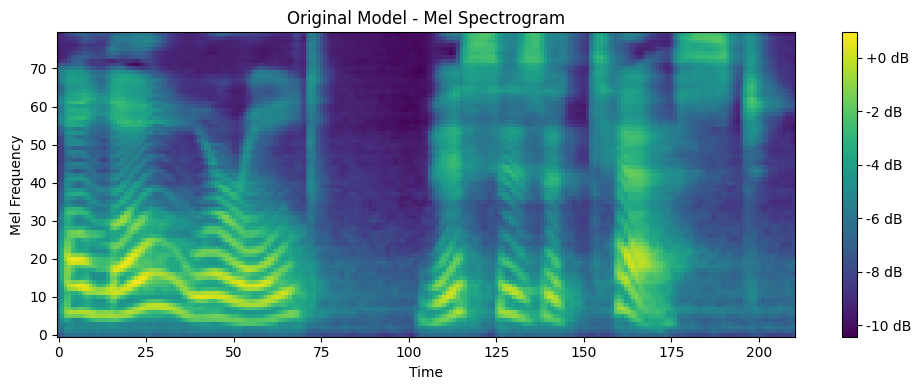

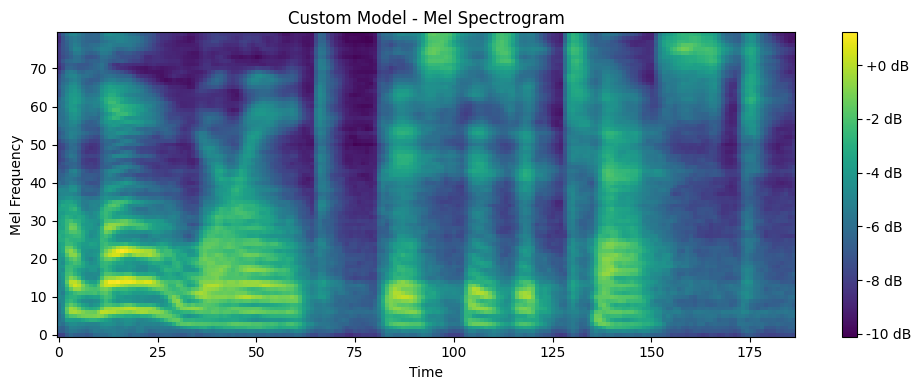

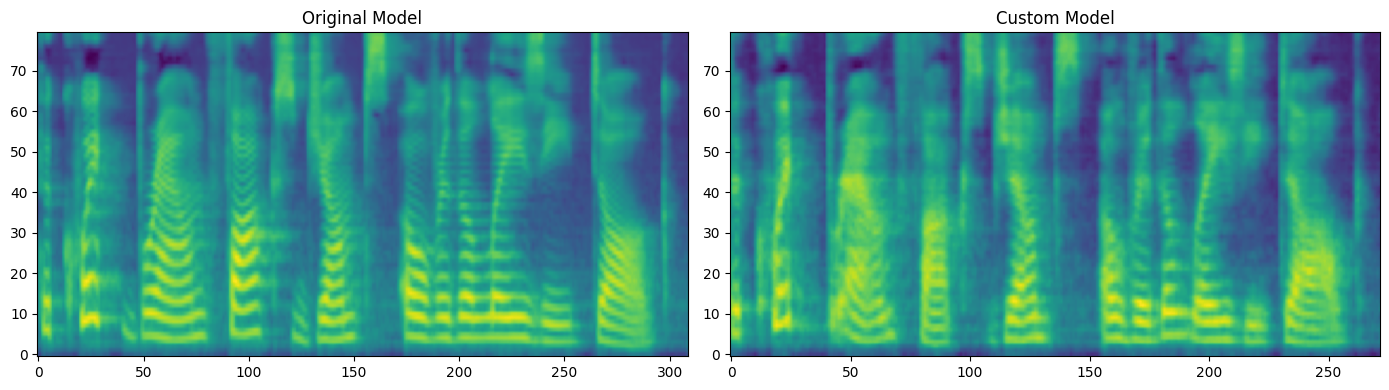

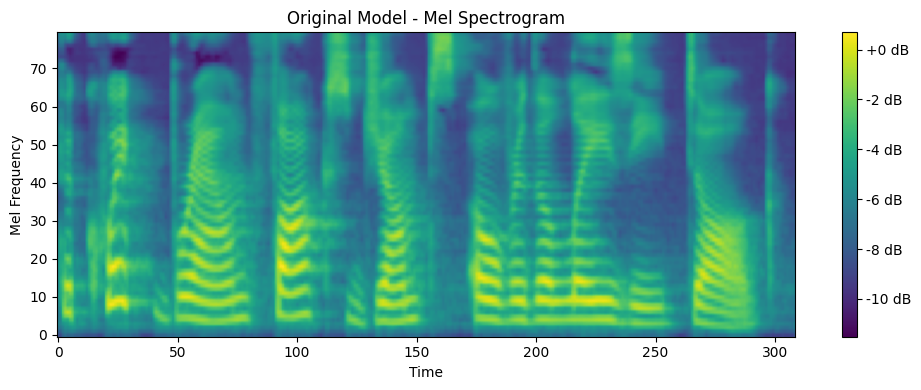

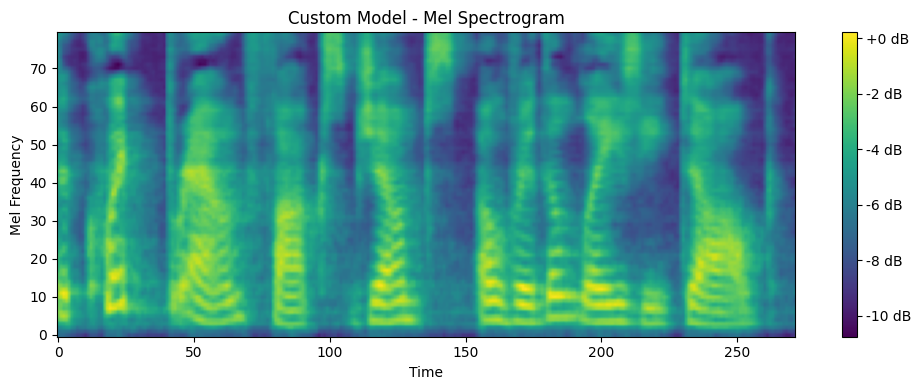

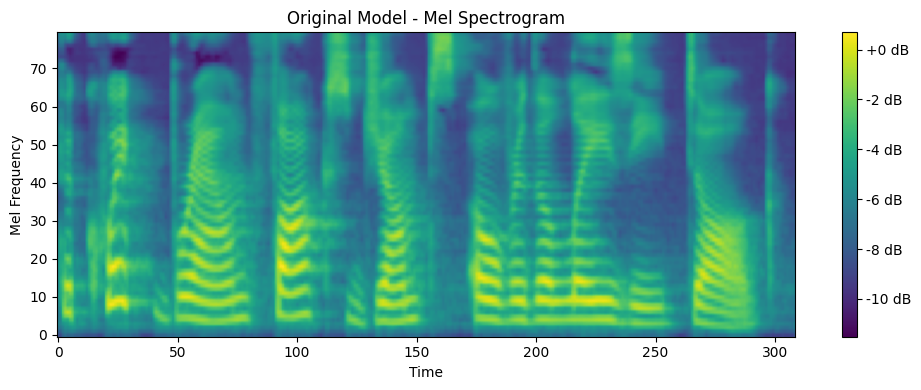

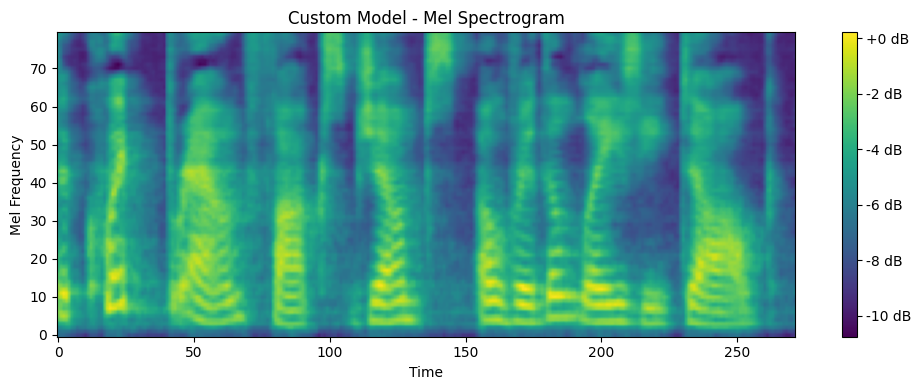

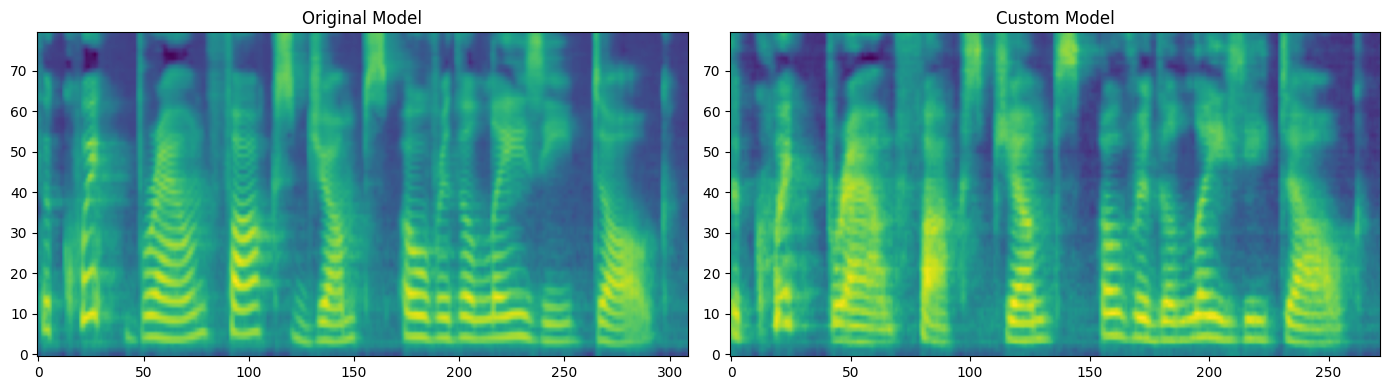

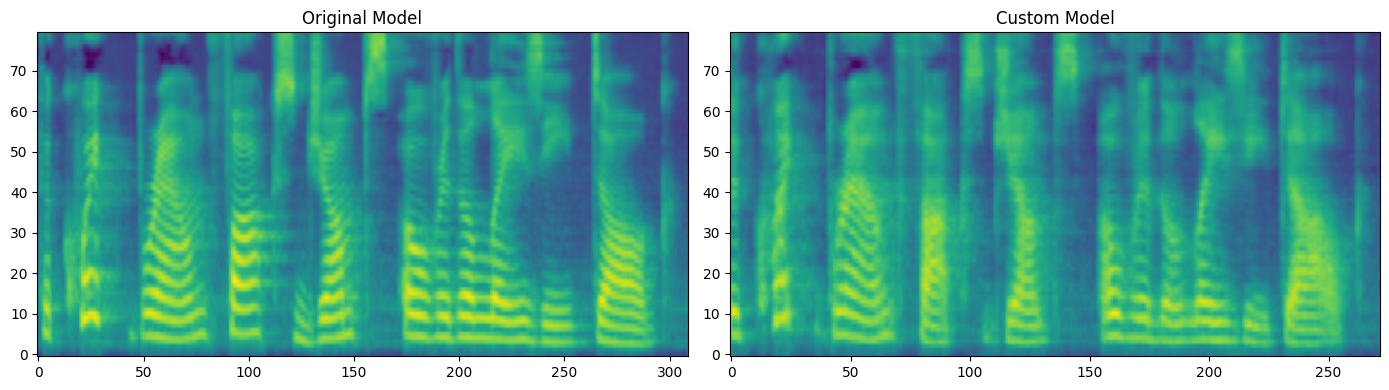

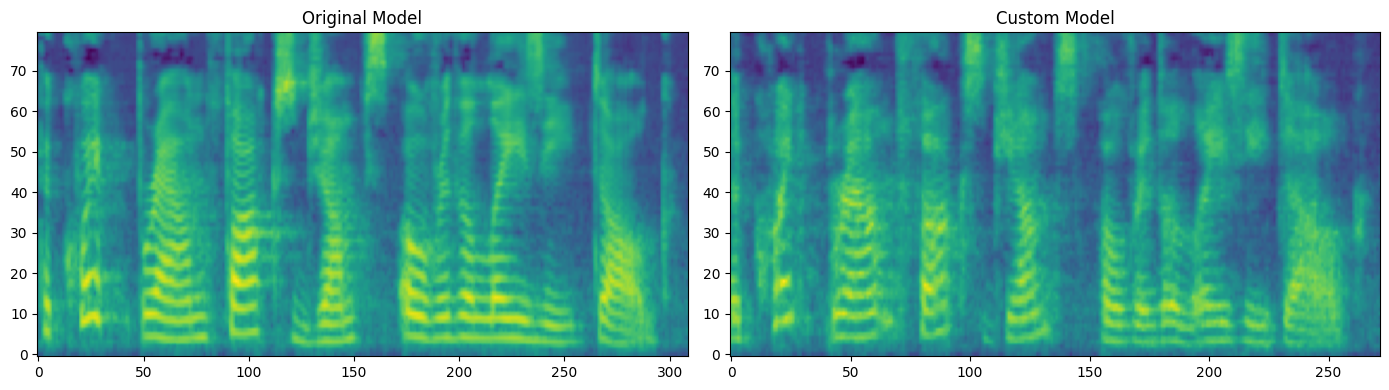

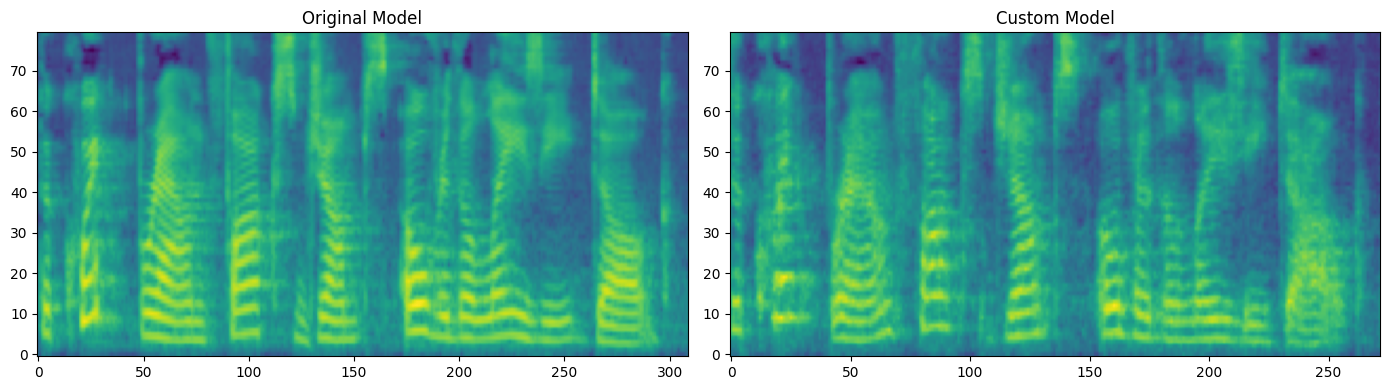

Original: 0.185s


Custom: 0.147s


In [20]:
text = "The quick brown fox jumps over the lazy dog."

o1 = synthesise(original_model, text,n_timesteps=20,temperature=1.0)
o1['audio'] = to_audio(o1['mel'])

o2 = synthesise(custom_model, text,n_timesteps=20,temperature=1.0)
o2['audio'] = to_audio(o2['mel'])

# Show mels side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].imshow(o1['mel'].squeeze().cpu().numpy(), origin='lower', aspect='auto', cmap='viridis')
axes[0].set_title('Original Model')
axes[1].imshow(o2['mel'].squeeze().cpu().numpy(), origin='lower', aspect='auto', cmap='viridis')
axes[1].set_title('Custom Model')
plt.tight_layout()
plt.show()

print(f"Original: {o1['time']:.3f}s")
ipd.display(ipd.Audio(o1['audio'], rate=22050))

print(f"Custom: {o2['time']:.3f}s")
ipd.display(ipd.Audio(o2['audio'], rate=22050))

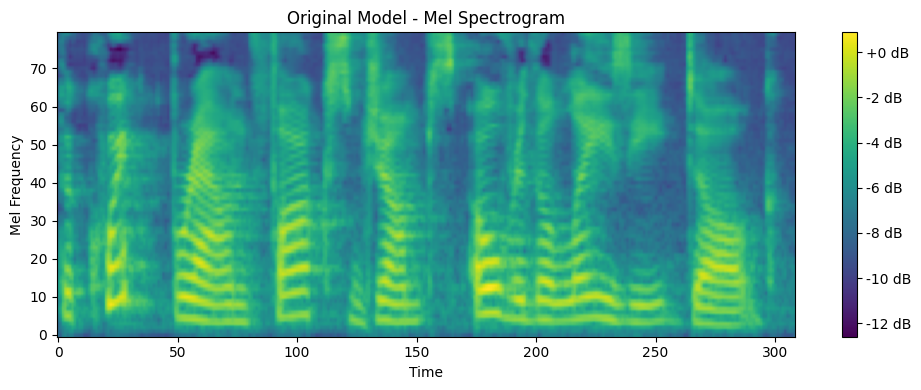

Original Model Mel Shape: torch.Size([1, 80, 309])


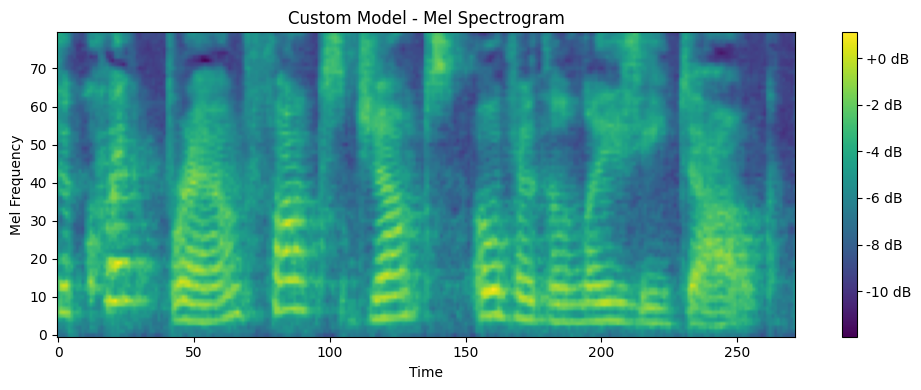

Original Model Mel Shape: torch.Size([1, 80, 272])


In [21]:
plt.figure(figsize=(10, 4))
plt.imshow(o1['mel'].squeeze().cpu().numpy(), origin='lower', aspect='auto', cmap='viridis')
plt.title('Original Model - Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

print(f"Original Model Mel Shape: {o1['mel'].shape}")

plt.figure(figsize=(10, 4))
plt.imshow(o2['mel'].squeeze().cpu().numpy(), origin='lower', aspect='auto', cmap='viridis')
plt.title('Custom Model - Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

print(f"Original Model Mel Shape: {o2['mel'].shape}")

In [14]:
Path("output").mkdir(exist_ok=True)
sf.write("output/original.wav", o1['audio'], 22050)
sf.write("output/custom.wav", o2['audio'], 22050)
np.save("output/original_mel.npy", o1['mel'].cpu().numpy())
np.save("output/custom_mel.npy", o2['mel'].cpu().numpy())